In [116]:
import pandas as pd
train_data = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")
sample = pd.read_csv("../data/sample_submission.csv")

In [117]:
import torch

train = train_data.iloc[:, 1:6]
labels = train_data["variable"]
print(train.shape, labels.shape)

X = torch.from_numpy(train.values).type(torch.float)
Y = torch.from_numpy(labels.values).type(torch.float)

T = torch.from_numpy(test.iloc[:, 1:6].values).type(torch.float)
T_test = torch.from_numpy(sample["0"].values).type(torch.float)

(47989, 5) (47989,)


In [118]:
from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train, X_test = X, T
Y_train, Y_test = Y, T_test
# X_test, X_train = X, T
# Y_test, Y_train = Y, T_test # это веселья ради

In [119]:
from torch import nn
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingWarmRestarts

features_n = 32

device = "cuda" if torch.cuda.is_available() else "cpu"

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=5, out_features=features_n)
        self.bn1 = nn.BatchNorm1d(features_n)  # Batch normalization
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=0.5)
        self.layer_2 = nn.Linear(in_features=features_n, out_features=features_n)
        self.bn2 = nn.BatchNorm1d(features_n)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=0.5)
        self.layer_3 = nn.Linear(in_features=features_n, out_features=features_n)
        self.bn3 = nn.BatchNorm1d(features_n)
        self.act3 = nn.ReLU()
        self.dropout3 = nn.Dropout(p=0.5)
        self.layer_4 = nn.Linear(in_features=features_n, out_features=1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.act1(self.bn1(self.layer_1(x)))
        x = self.dropout1(x)
        x = self.act2(self.bn2(self.layer_2(x)))
        x = self.dropout2(x)
        x = self.act3(self.bn3(self.layer_3(x)))
        x = self.dropout3(x)
        x = self.sigmoid(self.layer_4(x))
        return x

model = Model().to(device)
# Calculate class weights
num_zeros = torch.sum(Y_train == 0).item()
num_ones = torch.sum(Y_train == 1).item()
weight_for_1 =  num_zeros / num_ones # Higher weight for class 1
print(weight_for_1)
pos_weight = torch.tensor([weight_for_1]).to(device)

# Define loss function with pos_weight
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

# scheduler = StepLR(optimizer, step_size=1000, gamma=0.1)
# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=50, T_mult=2, eta_min=1e-5)

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()  # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

def recall_fn(y_true, y_pred):
    tp = torch.sum(torch.logical_and(y_true == 1, y_pred == 1)).item()
    recall = (tp / torch.sum(y_true == 1).item()) * 100
    return recall

torch.manual_seed(42)

epochs = 10000
X_train, X_test = X_train.to(device), X_test.to(device)
Y_train, Y_test = Y_train.to(device), Y_test.to(device)

for epoch in range(epochs):
    model.train()

    # Forward pass
    y_logits = model(X_train).squeeze()
    # print(y_logits)
    # print((y_logits == 0.).sum(dim=0))
    y_pred = torch.round(y_logits)  # Binary predictions (0 or 1)
    # Calculate loss and accuracy
    loss = loss_fn(y_logits, Y_train)  # Pass probabilities to loss function
    acc = accuracy_fn(y_true=Y_train, y_pred=y_pred)
    train_recall = recall_fn(y_true=Y_train, y_pred=y_pred)

    # Backpropagation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    # if (epoch % 500 == 0 and epoch < 20000):
    #     print(optimizer.param_groups[0]['lr'])
    
    # Evaluation
    model.eval()
    with torch.inference_mode():
        # Forward pass
        test_logits = model(X_test).squeeze()
        test_pred = torch.round(test_logits)  # Binary predictions (0 or 1)
        # Calculate test loss, accuracy, and recall
        test_loss = loss_fn(test_logits, Y_test)  # Pass probabilities to loss function
        test_acc = accuracy_fn(y_true=Y_test, y_pred=test_pred)
        test_recall = recall_fn(y_true=Y_test, y_pred=test_pred)

    # Print metrics
    if epoch % 500 == 0:

        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}%, Recall: {train_recall:.2f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%, Test recall: {test_recall:.2f}")

30.759761747187294
Epoch: 0 | Loss: 1.39533, Accuracy: 65.10%, Recall: 36.93 | Test loss: 8.16831, Test acc: 49.82%, Test recall: 0.00
Epoch: 500 | Loss: 1.17372, Accuracy: 83.38%, Recall: 74.52 | Test loss: 10.50495, Test acc: 50.12%, Test recall: 7.24
Epoch: 1000 | Loss: 1.14196, Accuracy: 87.84%, Recall: 74.06 | Test loss: 10.63373, Test acc: 50.12%, Test recall: 5.95
Epoch: 1500 | Loss: 1.13408, Accuracy: 88.85%, Recall: 74.12 | Test loss: 10.23280, Test acc: 50.31%, Test recall: 12.37
Epoch: 2000 | Loss: 1.12749, Accuracy: 88.83%, Recall: 76.04 | Test loss: 10.91107, Test acc: 49.92%, Test recall: 2.08
Epoch: 2500 | Loss: 1.12385, Accuracy: 89.08%, Recall: 76.17 | Test loss: 10.61832, Test acc: 50.20%, Test recall: 7.24
Epoch: 3000 | Loss: 1.12051, Accuracy: 89.55%, Recall: 76.77 | Test loss: 10.38235, Test acc: 50.34%, Test recall: 11.40
Epoch: 3500 | Loss: 1.12178, Accuracy: 88.40%, Recall: 77.90 | Test loss: 10.66924, Test acc: 50.17%, Test recall: 6.36
Epoch: 4000 | Loss: 1.12

In [120]:
import numpy as np

def accuracy_fn_np(y_true, y_pred):
    correct = np.sum(y_true == y_pred)  # np.sum() calculates the number of equal elements
    acc = (correct / len(y_pred)) * 100
    return acc

def recall_fn_np(y_true, y_pred):
    tp = np.sum((y_true == 1) & (y_pred == 1))  # True positives
    recall = (tp / np.sum(y_true == 1)) * 100
    return recall

Test confusion matrix

[0 0 0 ... 0 0 0]
(20568,)
(20568,)
50.18475301439129


Text(0.5, 1.0, 'Confusion Matrix')

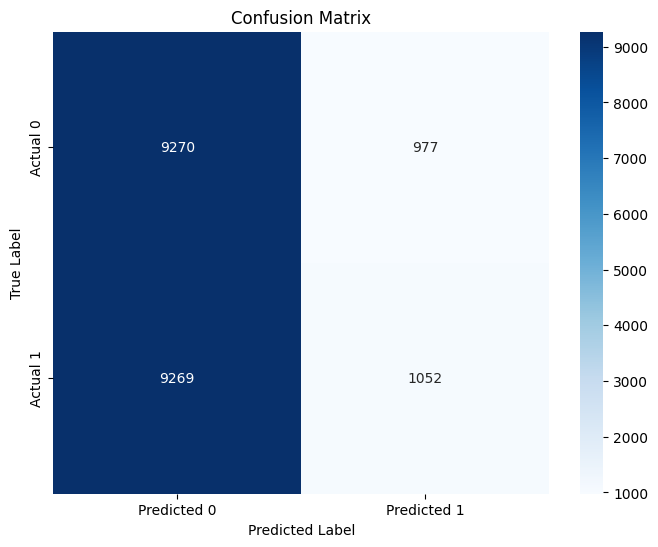

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_pred = test.iloc[:, 1:6].values
test_pred = torch.from_numpy(test_pred).type(torch.float).to(device)
test_pred = torch.round(model(test_pred)).squeeze()

test_pred = test_pred.cpu()
test_pred = test_pred.detach()
test_pred = test_pred.numpy()
test_true = sample["0"].values
print(test_true)
print(test_true.shape)
print(test_pred.shape)
print(accuracy_fn_np(test_true, test_pred))

# Compute the confusion matrix
cm = confusion_matrix(test_true, test_pred)

# Plot the confusion matrix using Seaborn's heatmap
plt.style.use("default")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
# plt.show()
# test_pred

Train confusion matrix

[1 0 0 ... 0 0 0]
(47989,)
(47989,)
91.45012398674697


Text(0.5, 1.0, 'Confusion Matrix')

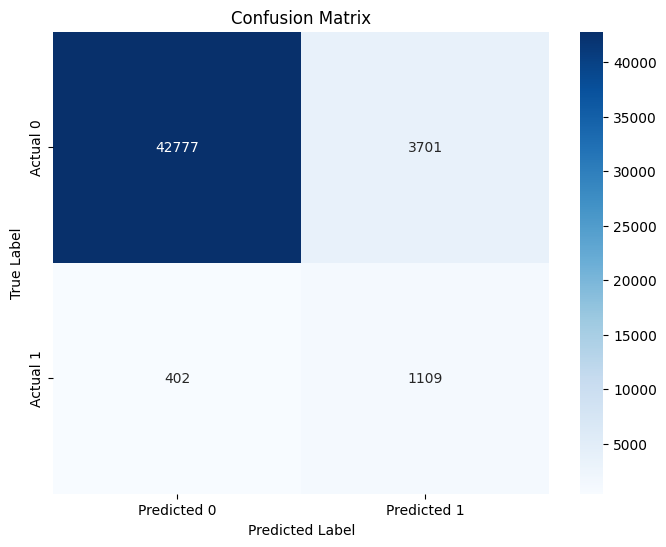

In [123]:
train = pd.read_csv("../data/train.csv")
train_pred = train.iloc[:, 1:6].values
train_pred = torch.from_numpy(train_pred).type(torch.float).to(device)
train_pred = torch.round(model(train_pred)).squeeze()

train_pred = train_pred.cpu()
train_pred = train_pred.detach()
train_pred = train_pred.numpy()
train_true = train["variable"].values
print(train_true)
print(train_true.shape)
print(train_pred.shape)
print(accuracy_fn_np(train_true, train_pred))

# Compute the confusion matrix
cm = confusion_matrix(train_true, train_pred)

# Plot the confusion matrix using Seaborn's heatmap
plt.style.use("default")
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
# plt.show()
# train_pred